In [27]:
import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="bright", font_scale=1.1)

In [2]:
!git clone https://personalaccesstoken@github.com/Aaaanastasia/Payoneer_test_task.git

Cloning into 'Payoneer_test_task'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 70.47 KiB | 23.49 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [64]:
#load all datasets
df_bots = pd.read_excel('/content/Payoneer_test_task/task/Payoneer_DA_Compliance_Test.xlsx', index_col=0, sheet_name='Q1_Bots')
#df_bots_info = pd.read_excel('/content/Payoneer_test_task/task/Payoneer_DA_Compliance_Test.xlsx', index_col=0, sheet_name='Q2_Assisting_Information')
df_payments = pd.read_excel('/content/Payoneer_test_task/task/Payoneer_DA_Compliance_Test.xlsx', index_col=0, sheet_name='Q3_Incoming_Payments')
df_edd = pd.read_excel('/content/Payoneer_test_task/task/Payoneer_DA_Compliance_Test.xlsx', index_col=0, sheet_name='Q3_EDD_Reviews')

#1. ***Question 1:***

> <div>You received an alert about suspected bots registering through our platform. The registration phase has 4 steps, each requiring the user to enter information such as first and last name, addresses, purpose of user and more. A user moves on to the next step after completing the previous step.</div> <br><div>To identify the bots you sampled a list of Customers registering and their start-time for each step. Please write a query that will print out users and a column with some measure you created that will help you identify if users are bots (The query does not need to compile seamlessly, though you're welcome to have it so)</div>

#2. ***Question 2:***

> <div>You are requested to summarize your findings to another Compliance manager explaining who are the suspected bots and how did you identify them.
</div>

In [65]:
df_bots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 1798518 to 27287015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   StepId     116 non-null    int64 
 1   StartTime  116 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.7+ KB


In [66]:
# Correct datatypes timestamps shoul be in datatime type
df_bots['StartTime'] = pd.to_datetime(df_bots['StartTime'])

In [67]:
#Examine data
df_bots = df_bots.sort_values(['CustomerId', 'StepId', 'StartTime'])
df_bots.head()

,StepId,StartTime
CustomerId,,
1798518,1,2024-12-02 01:20:20.423
1798518,2,2024-12-02 01:21:33.110
1798518,3,2024-12-02 01:22:16.957
1798518,4,2024-12-02 01:24:17.947
14270035,1,2024-12-03 08:14:46.800


In [68]:
# Now to get the anomaly we need to calculate time between steps per user
df_bots['Next_step_time'] = df_bots.groupby('CustomerId')['StartTime'].shift(-1)
df_bots['Time_diff_seconds'] = (df_bots['Next_step_time'] - df_bots['StartTime']).dt.total_seconds()

In [69]:
# Calculate total time for all steps per user
df_bots['Total_time'] = (df_bots.groupby('CustomerId')['StartTime'].max() - df_bots.groupby('CustomerId')['StartTime'].min()).dt.total_seconds()

In [70]:
"""
Lets dive into basic data statistical indicators and features
We already can see that are a large range between the minimum and maximum time difference between steps and total tipe for steps per user,
as well as a large difference between the average and the median.
"""
desc = df_bots.describe().T
desc['empty'] =  len(df_bots) - desc['count']
desc['zero'] = df_bots.isin([0]).sum()
display(desc)

,count,mean,min,25%,50%,75%,max,std,empty,zero
StepId,116.0,2.5,1.0,1.75,2.5,3.25,4.0,1.122884,0.0,0
StartTime,116,2024-12-15 19:50:33.914473984,2024-12-02 01:20:20.423000,2024-12-06 16:34:49.276000,2024-12-17 15:08:20.046499840,2024-12-23 05:21:40.594999808,2024-12-30 12:02:58.113000,NaN,0,0
Next_step_time,87,2024-12-15 19:50:58.869229824,2024-12-02 01:21:33.110000,2024-12-06 16:35:19.388499968,2024-12-17 15:08:36.312999936,2024-12-23 05:21:40.820000256,2024-12-30 12:02:58.113000,NaN,29,0
Time_diff_seconds,87.0,50.631149,0.5,32.1885,51.667,67.965,136.956,31.145079,29.0,0
Total_time,116.0,151.893448,2.3,143.6,166.307,195.083,237.524,65.340759,0.0,0


In [71]:
#Lets research the difference per steps per users more
user_stats = df_bots.groupby('CustomerId', as_index=False)[['Time_diff_seconds']].agg([
    'mean', 'min', 'max', 'std', 'count'
]).droplevel(axis=1, level=0).rename(columns={
    '' : 'customerId',
    'mean': 'avg_time',
    'min': 'min_time',
    'max': 'max_time',
    'std': 'std_time',
    'count': 'steps_count'
})

In [26]:
user_stats.head()

,customerId,avg_time,min_time,max_time,std_time,steps_count
0,1798518,79.174667,43.847,120.990,38.978558,3
1,14270035,61.329000,31.340,86.160,27.771601,3
2,14566449,71.641000,54.313,82.574,15.177057,3
3,14680928,47.503333,21.340,78.843,29.098876,3
4,15578183,0.933333,0.700,1.100,0.208167,3


In [72]:
# Lets calculate the threshold for time difference disribution statiscically
Q1 = user_stats['avg_time'].quantile(0.25)
Q3 = user_stats['avg_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
print(f"IQR Threshold (lower bound): {lower_bound:.2f} seconds")

IQR Threshold (lower bound): 22.13 seconds


### Threshold Calculation for Bot Detection

To identify users with suspiciously fast registration times, we used the **Interquartile Range (IQR)** method, becouse unlike standard deviation, IQR is not affected by extreme values and is great for behavioral data that may not be normally distributed:

*   **IQR (Interquartile Range)**: `IQR = Q3 - Q1` — represents the middle 50% spread of the data   
*   **Lower bound** for outlier detection: `Q1 - 1.5 * IQR`

Users whose **average step time is below this lower bound** are flagged as potential bots due to their unusually fast progression through the registration steps.

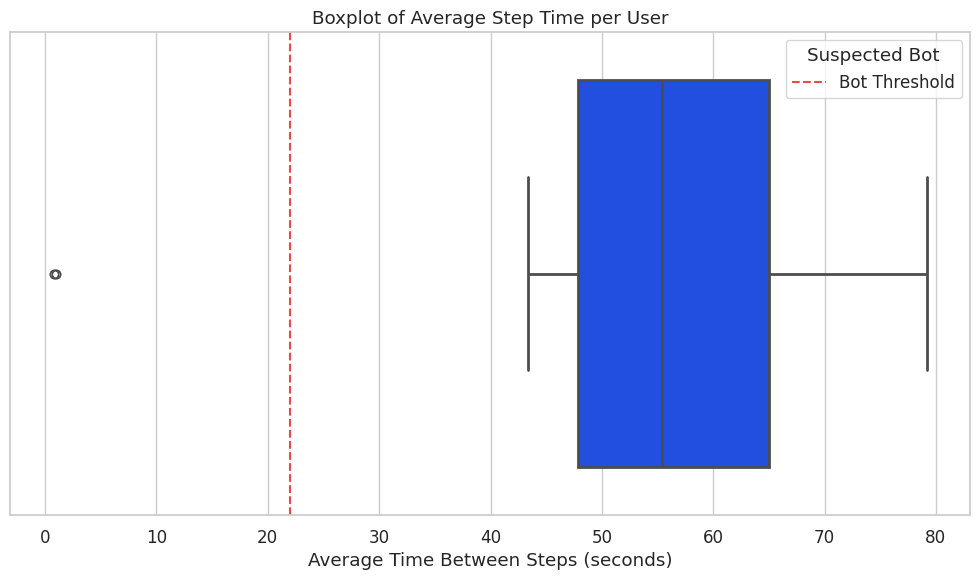

In [73]:
# Sort out the style
#sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
sns.set(style="whitegrid", palette="bright", font_scale=1.1)

# Create the figure
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(
    x='avg_time',
    data=user_stats,
    #color='#AED6F1',
    linewidth=2
)

# Aesthetics
plt.axvline(22, color='#E74C3C', linestyle='--', label='Bot Threshold')
plt.title('Boxplot of Average Step Time per User')
plt.xlabel('Average Time Between Steps (seconds)')
plt.legend(title='Suspected Bot', loc='upper right')
plt.tight_layout()
plt.show()

### Average Step Time Per User

The boxplot above shows the distribution of **average time between steps** during user registration.

The **red line** at 22 seconds marks a threshold below which user behavior is considered suspicious.

Users flagged as **suspected bots** (in red) tend to have:
  - Extremely fast completion times between steps (often < 1 second),
  - Very **low variance**, suggesting automated behavior.

In [74]:
# Lets detect suspected bots
user_stats['suspected_bot'] = user_stats['avg_time'] < lower_bound

In [75]:
user_stats.head()

,customerId,avg_time,min_time,max_time,std_time,steps_count,suspected_bot
0,1798518,79.174667,43.847,120.990,38.978558,3,False
1,14270035,61.329000,31.340,86.160,27.771601,3,False
2,14566449,71.641000,54.313,82.574,15.177057,3,False
3,14680928,47.503333,21.340,78.843,29.098876,3,False
4,15578183,0.933333,0.700,1.100,0.208167,3,True


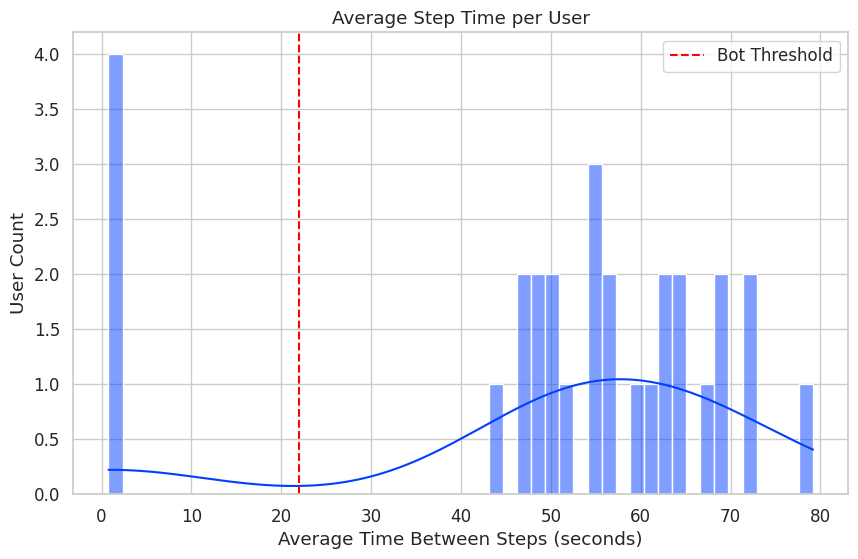

In [76]:
# Distribution of average step time
plt.figure(figsize=(10, 6))
sns.histplot(user_stats['avg_time'], bins=50, kde=True)
plt.axvline(22, color='red', linestyle='--', label='Bot Threshold')
plt.title('Average Step Time per User')
plt.xlabel('Average Time Between Steps (seconds)')
plt.ylabel('User Count')
plt.legend()
plt.show()

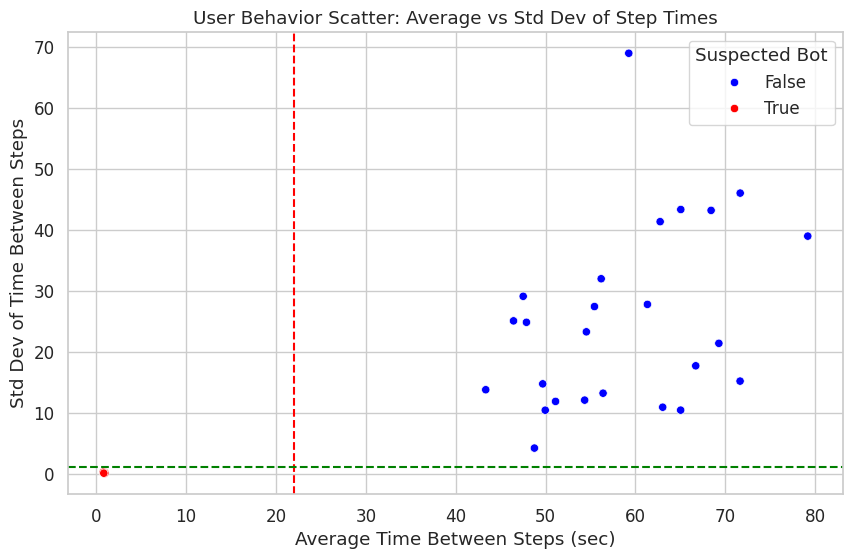

In [77]:
# Scatter plot: average vs std dev
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=user_stats,
    x='avg_time',
    y='std_time',
    hue='suspected_bot',
    palette={True: 'red', False: 'blue'}
)
plt.axvline(22, color='red', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.title('User Behavior Scatter: Average vs Std Dev of Step Times')
plt.xlabel('Average Time Between Steps (sec)')
plt.ylabel('Std Dev of Time Between Steps')
plt.legend(title='Suspected Bot')
plt.show()

### User Step Timing – Distribution and Behavioral Patterns

To detect suspected bots, we analyzed the **average time between registration steps** for each user. Two key visualizations support this analysis:

---

#### 1. Histogram: Average Step Time per User

This chart shows the distribution of users’ average time between form steps.

- The **KDE curve** (blue) illustrates the density of user behavior.
- The **red dashed line** at 22 seconds marks the **IQR-based lower bound threshold** for detecting anomalies.
- Users to the **left of this threshold** submitted information significantly faster than the majority, a strong indication of automated activity.

---

#### 2. Scatter Plot: Average Time vs Standard Deviation

This plot provides a two-dimensional view of user behavior by comparing:

- **X-axis**: Average time between steps  
- **Y-axis**: Standard deviation of those times (how consistent the user was)

Key insights:
- **Red dots** represent users flagged as suspected bots.
- Bots tend to cluster in the **lower-left corner** — showing both low average time and very little variation (i.e., extremely fast and consistent — typical for scripts).
- The **green line** at Std Dev = 1 and **red vertical line** at Avg Time = 22 seconds mark the soft thresholds for natural behavior.

Together, these plots clearly highlight **outliers who behave too quickly and consistently** to be genuine users — strengthening our bot detection model both statistically and visually.

In [78]:
print(f"Suspected bots: {user_stats['suspected_bot'].sum()} users")

suspected = user_stats[user_stats['suspected_bot']].sort_values('avg_time')
display(suspected.head(20))

Suspected bots: 4 users


,customerId,avg_time,min_time,max_time,std_time,steps_count,suspected_bot
20,24332668,0.766667,0.50,0.9,0.230940,3,True
23,25008550,0.830000,0.79,0.9,0.060828,3,True
4,15578183,0.933333,0.70,1.1,0.208167,3,True
13,20057177,0.956667,0.90,1.0,0.051316,3,True


### Summary: Bot Detection During Registration


**Total users analyzed:**

*   ~30 (based on visual review)
*   Users flagged as bots: 4 users

These users had:

*   Average time between 0.76 and 0.95 seconds
*   Very low standard deviation in timing (e.g., 0.05 – 0.23s)
*   All completed 3 steps in rapid, consistent succession.

#3. ***Question 3:***

><div>One of the compliance managers thinks we have a bug in our system affecting the Enhanced Due Diligence procedure (EDD) — a comprehensive review of customer information). The procedure requires us to review accounts before they reach a balance of 1000. In other words, before they load more than 1,000 into their account.</div><br><div>Assuming the payments in sheet "Q3_Incoming_Payments" remain in balance - that is, no funds are leaving the user between payments - Write a query that will output the list of users who had their EDD review after they received a total of 1000 dollars.</div> <br><div>The output fields are not critical (what columns you include in the output) as long as it contains only the requested list of users.
For example, user 48638892 had his EDD review after he had already loaded a total of ~$1,108, so we’d expect to see him in the output.</div>

In [86]:
df_payments.info()
df_edd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 32894092 to 90077471
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Transaction_Datetime  41 non-null     object 
 1   Volume_Amount_USD     41 non-null     float64
dtypes: float64(1), object(1)
memory usage: 984.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 32894092 to 90077471
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   edd_review  6 non-null      object
dtypes: object(1)
memory usage: 96.0+ bytes


In [87]:
# Changing the type of date columns into datetime format
df_payments['Transaction_Datetime'] = pd.to_datetime(df_payments['Transaction_Datetime'], format='ISO8601', errors='coerce')
df_edd['edd_review'] = pd.to_datetime(df_edd['edd_review'])

In [88]:
df_payments.head()

,Transaction_Datetime,Volume_Amount_USD
CustomerID,,
32894092,2024-12-01 21:33:31.407,111.8940
32894092,2024-12-02 21:33:31.407,105.6747
32894092,2024-12-04 21:05:50.327,162.8604
32894092,2024-12-08 21:32:06.043,122.4883
32894092,2024-12-15 21:31:43.243,326.8326


In [89]:
df_edd.head()

,edd_review
CustomerID,
32894092,2024-12-15 21:41:43.243
48638892,2025-01-03 05:25:39.297
77852042,2025-01-11 12:08:18.423
84242950,2024-12-18 21:06:37.683
87069989,2024-12-16 09:48:13.457


In [93]:
# Lets calculate cumulative balance and sort data by transaction date per user
df_payments['cumulative_usd'] = df_payments.groupby('CustomerID')['Volume_Amount_USD'].cumsum()
df_payments = df_payments.sort_values(['CustomerID', 'Transaction_Datetime'])

In [94]:
df_payments.head()

,Transaction_Datetime,Volume_Amount_USD,cumulative_usd
CustomerID,,,
32894092,2024-12-01 21:33:31.407,111.8940,111.8940
32894092,2024-12-02 21:33:31.407,105.6747,217.5687
32894092,2024-12-04 21:05:50.327,162.8604,380.4291
32894092,2024-12-08 21:32:06.043,122.4883,502.9174
32894092,2024-12-15 21:31:43.243,326.8326,829.7500


In [95]:
# Now lets calculate the first time each user crossed $1000
cross_time = (
    df_payments[df_payments['cumulative_usd'] >= 1000]
    .groupby('CustomerID')['Transaction_Datetime']
    .min()
    .reset_index()
    .rename(columns={'Transaction_Datetime': 'time_crossed_1000'})
)

In [97]:
# Now lets merge (left join) two datasets and check for violations
combined = cross_time.merge(df_edd, on='CustomerID', how='left')
violations = combined[combined['edd_review'] > combined['time_crossed_1000']]

In [98]:
# Show results
print("Customers who passed $1000 before EDD review:")
print(violations['CustomerID'].tolist())

Customers who passed $1000 before EDD review:
[48638892, 84242950]


<ipython-input-99-b75e73c50ceb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary.values, palette='Set2')


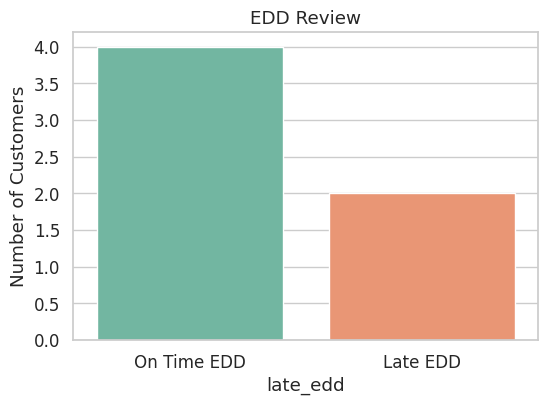

In [99]:
# Classify customers
combined['late_edd'] = combined['edd_review'] > combined['time_crossed_1000']
summary = combined['late_edd'].value_counts().rename({True: 'Late EDD', False: 'On Time EDD'})

plt.figure(figsize=(6, 4))
sns.barplot(x=summary.index, y=summary.values, palette='Set2')
plt.title('EDD Review')
plt.ylabel('Number of Customers')
plt.show()

### EDD Compliance Summary

The bar chart above summarizes whether customers passed the **Enhanced Due Diligence (EDD)** review **before** or **after** exceeding the $1,000 threshold in incoming payments.

- **"On Time EDD"**: Customers who were reviewed before loading $1,000, in line with policy.
- **"Late EDD"**: Customers who crossed the threshold before their EDD review, indicating a compliance issue.

This classification was done by comparing each customer's cumulative payment timestamp with their EDD review time. The chart helps Compliance teams quickly assess whether procedural timing is being followed and highlights areas where policy enforcement may need to be strengthened.

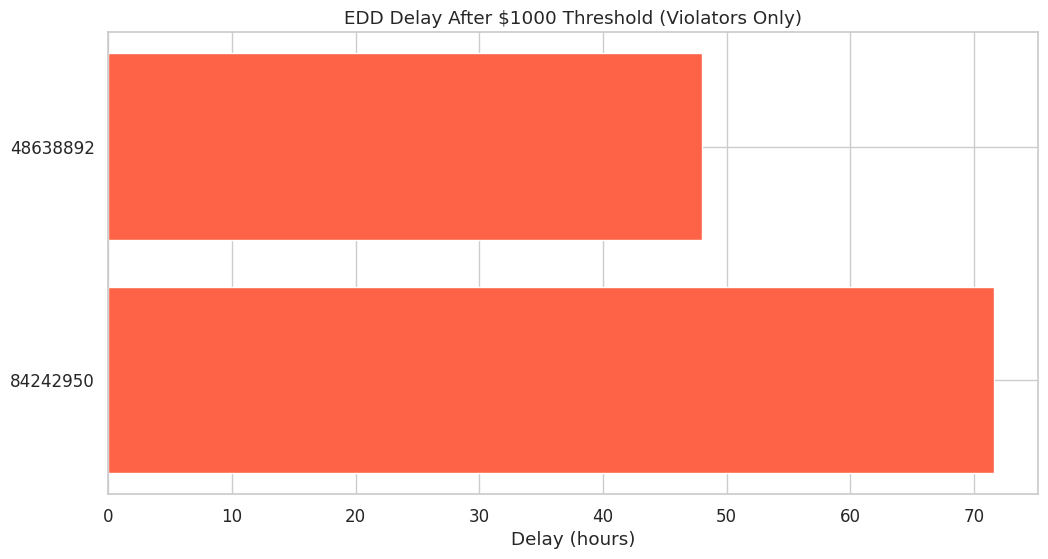

In [100]:
plot_df = violations.copy()
plot_df['edd_review'] = pd.to_datetime(plot_df['edd_review'])
plot_df['time_crossed_1000'] = pd.to_datetime(plot_df['time_crossed_1000'])

plt.figure(figsize=(12, 6))
plot_df = plot_df.sort_values('edd_review')

plt.barh(plot_df['CustomerID'].astype(str), (plot_df['edd_review'] - plot_df['time_crossed_1000']).dt.total_seconds()/3600,
         color='tomato')
plt.xlabel('Delay (hours)')
plt.title('EDD Delay After $1000 Threshold (Violators Only)')
plt.show()

### EDD Delay Analysis for Policy Violators

This horizontal bar chart displays the **delay (in hours)** between the time customers **crossed the $1,000 threshold** and when their **EDD review** was completed — for users who **violated** the compliance policy.

- Each bar represents a customer who received their EDD review **after** they had already received more than $1,000 in incoming payments.
- The **length of the bar** corresponds to the delay in hours between the two events.

This visualization provides a **clear measurement of compliance lag** per customer and helps prioritize reviews where delays were significant. It is particularly useful for identifying recurring issues or systemic slowdowns in the EDD process.

### Summary: EDD Timing Compliance

***1. Users Who Violated the EDD Timing Policy***

*   2 customers were flagged as having their EDD review after crossing the $1000 threshold. (ID: 48638892, 84242950). They loaded over 1000 into their account before the EDD review was completed, which violates the policy.

***2. Compliance Breakdown***

*   4 users had their EDD review on time
*   2 users had late EDD reviews

***3. EDD Delay Insight***

*   The delay between crossing $1000 and EDD review ranged from a few hours to over a day, depending on the customer.
